Exemplo de aplicação do algoritmos de ICA para a separação de 4 sinais de áudio, assim como as avaliações de desempenho.

In [ ]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
import museval
import musdb
from IPython.display import Audio
from scipy import stats

In [3]:
pathdata = ''
pathestimators = ''

In [4]:
#s1, sr = librosa.load('goat.wav', duration = 10)
s1, sr = librosa.load('D:/Audios/Novos/data/vehicle/Misturas/test/Mistura 2/source1.wav', duration = 10)
s2, sr = librosa.load('D:/Audios/Novos/data/vehicle/Misturas/test/Mistura 2/source2.wav', duration = 10)
s3, sr = librosa.load('D:/Audios/Novos/data/vehicle/Misturas/test/Mistura 2/source3.wav', duration = 10)
s4, sr = librosa.load('D:/Audios/Novos/data/vehicle/Misturas/test/Mistura 2/source4.wav', duration = 10)
#s2, sr = librosa.load('balaclava.wav', duration = 10)
#s3, sr = librosa.load('scary.wav', duration = 10)
#mus = musdb.DB()
#print(mus)

In [5]:
S = np.array([s1, s2, s3, s4])
A = np.random.rand(len(S),len(S))
X = A.dot(S)

In [6]:
w = np.random.rand(len(X), 1)
w = w/np.linalg.norm(w)
winfomax = np.random.rand(len(X), len(X))

In [7]:
def mistura(Sn):
    A = np.random.randn(len(S), len(S))
    X = A.dot(Sn)
    return X, A

In [8]:
def whitening(X):
    Xm = X - X.mean()
    covXm = np.cov(Xm)
    I = np.eye(len(X))
    evalor, evetor = np.linalg.eig(covXm)
    wevalor = np.diag(1/(evalor**0.5))
    z = np.dot(wevalor.dot(evetor.T),Xm)
    return z, wevalor

In [9]:
def normaliza(v):
    vn = [k/np.std(k) for k in v]
    return np.array(vn)

In [10]:
def correlacao(Sn, Yn, X):
    #Cálculo da correlação de Pearson e separação dos pares de maior correlação
    allarrays = list()
    for p in range (0,len(X)): #Para comparar com S[0] e S[1]
        corrnova = 0
        corr = 0
        arrays = list()
        for o in range(0,len(X)): #Para comparar com Yn[0] e Yn[1]
            corrnova = stats.pearsonr(Sn[p],Yn[o])
            print(f'Correlação de Pearson vale {stats.pearsonr(Sn[p], Yn[o])[0]} entre a {p+1} linha de S e a {o+1} linha de Y')
            if np.abs(corrnova[0]) > np.abs(corr): 
                corr = corrnova[0]
                arrays.clear()
                if corr < 0:
                    Yn[o] = Yn[o] * -1
                arrays.append(((Sn[p], Yn[o]),(p,o)))
        allarrays.append(arrays)
    return allarrays 
#Sn[p] e Y[o] são os pares de componentes com maior correlação
#retorna o vetor com os pares de maior correlaçao acompanhado de uma tupla (p,o) em que p é a posiçao de S[p] e o é a posição de Y[o]

In [11]:
def musevaluation(pares):
    #print(pares)
    results = museval.EvalStore(frames_agg='median', tracks_agg='median')
    results.add_track(museval.eval_mus_track(x1,x2))
    print(results)
    return results

In [12]:
def mse(pares):
    #A variável pares corresponde ao vetor com os pares de maior correlação
    mseall = list()
    msgrafs = list()
    for x in pares:
        mse = 0
        msgraf = list()
        for ponto in range (0, X.shape[1]):
            sqr = (x[0][0][0][ponto]- x[0][0][1][ponto])**2
            msgraf.append(sqr)
            mse += sqr
        msgrafs.append(msgraf)
        mse = mse/X.shape[1]
        posicao = x[0][1] #guarda posiçao das linhas de maior correlaçao
        mseall.append((mse, posicao))
    for z in mseall:
        print(f'O erro quadrático médio entre a {(z[1][0])+1}ª linha de S e a {(z[1][1])+1}ª linha de Y é de {z[0]}')
    return mseall 
#retorna array com o erro quadratico medio e suas posições correspondentes 

In [13]:
def amari2(w, a):
    p = w.dot(a)
    A = B = 0
    for c in range(len(w)):
        a = b = 0
        for d in range(len(w)):
            a += (np.abs(p[c][d])/np.max(np.abs(p[c,:])))
            b += (np.abs(p[d][c])/np.max(np.abs(p[:,c])))
        A += a-1
        B += b-1
    E = A+B
    print(f'O índice de Amari obtido para W é de {E}')
    return E

In [23]:
def grafsmse(nome, mseall, Sn, Yn):
    for a in mseall:
        print(len(mseall))
        indexS = a[1][0]
        indexY = a[1][1]
        plt.figure(figsize = (14,5))
        plt.title(f'Erro quadrático médio para algoritmo {nome}')
        plt.plot(Sn[indexS])
        plt.plot(Yn[indexY])
        plt.legend(['Sinal Original', 'Sinal Separado'], loc = 'lower left')

In [15]:
def curtose(w, z, rate= 0):
    nome = "FastICA com Curtose"
    wlist = list()
    m = len(z)
    w1 = w
    for p in range (1, m+1):
        w1 = (((w1.T.dot(z)**3).dot(z.T)).T/X.shape[1])-3*w1
        w1 = w1/np.linalg.norm(w1)
        if p > 1:
            for j in range(1, p):
                a = w1.T.dot(wlist[j-1])
                w1 = w1 - (a[0]*wlist[j-1])
            w1 = w1/np.linalg.norm(w1)
        wlist.append(w1)
    W = list()
    for o in wlist:
        wfinal = list()
        for numP, p in enumerate(o):
            nw= p[0]
            wfinal.append(nw)
            if numP == len(o)-1:
                W.append(wfinal)            
    W = np.array(W)
    return nome, W

In [16]:
#Algoritmo de FastICA com negentropia
def negentropia(w, z, rate = 0):
    nome = "FastICA com Negentropia"
    wlist = list()
    m = len(z)
    for p in range (1, m+1):
        w = (z.dot((np.tanh(w.T.dot(z)).T)))/X.shape[1] - (np.sum((1-(np.tanh(w.T.dot(z))**2))/X.shape[1])*w)
        w = w/np.linalg.norm(w)
        if p > 1:
            for j in range(1, p):
                a = w.T.dot(wlist[j-1])
                w = w- (a[0]*wlist[j-1])
            w = w/np.linalg.norm(w)
        wlist.append(w)
    W = list()
    for o in wlist:
        wfinal = list()
        for numP, p in enumerate(o):
            nw= p[0]
            wfinal.append(nw)
            if numP == len(o)-1:
                W.append(wfinal)            
    W = np.array(W)
    return nome, W

In [17]:
#Algoritmo Infomax
def infomax(W, x, rate):
    nome = "Infomax"
    I = np.eye(len(X), len(X))
    for k in range (0,X.shape[1]):
       # print(X[:,k] , len(X[:,k]))
        y = W.dot(X[:,k])
        fy = [[np.tanh(y[m])] for m in range (len(X))]
        W = W + rate*np.dot(I-(fy*y.T),(W))
    return nome, W

In [18]:
def teste(S,X, algoritmo, w,A,rate = 0, white = False):
    Sn = normaliza(S)
    if white == True:
        X, wwhite = whitening(X)
    nome, W = algoritmo(w, X, rate)
    try:
        y = W.dot(X)
    except(ValueError):
        y = np.transpose(W).dot(X)
    print(f'Nome do algoritmo: {nome}')
    Yn = normaliza(y)
    if white == True:
        W = W.dot(wwhite)
    amari = amari2(W,A)
    pares = correlacao(Sn,Yn, X)
    #sf.write('stereo_file.wav', data, samplerate, subtype='PCM_24')
    #scores = musevaluation("stereofile.wav")
    mses = mse(pares)
    grafsmse(nome, mses, Sn, Yn)

In [19]:
print(S.shape, A.shape, w.shape, winfomax.shape, X.shape)

(4, 220500) (4, 4) (4, 1) (4, 4) (4, 220500)


Nome do algoritmo: FastICA com Curtose
O índice de Amari obtido para W é de 10.866927733145971
Correlação de Pearson vale -0.004252742343800994 entre a 1 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.04017345643820665 entre a 1 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.11813176333143385 entre a 1 linha de S e a 3 linha de Y
Correlação de Pearson vale -0.9921758382829994 entre a 1 linha de S e a 4 linha de Y
Correlação de Pearson vale 0.009699632970863157 entre a 2 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.44075780610327897 entre a 2 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.8893597930006889 entre a 2 linha de S e a 3 linha de Y
Correlação de Pearson vale -0.12115127763678724 entre a 2 linha de S e a 4 linha de Y
Correlação de Pearson vale -0.998831253850795 entre a 3 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.04696790506759339 entre a 3 linha de S e a 2 linha de Y
Correlação de Pearson vale -0.011162758514548522 entr

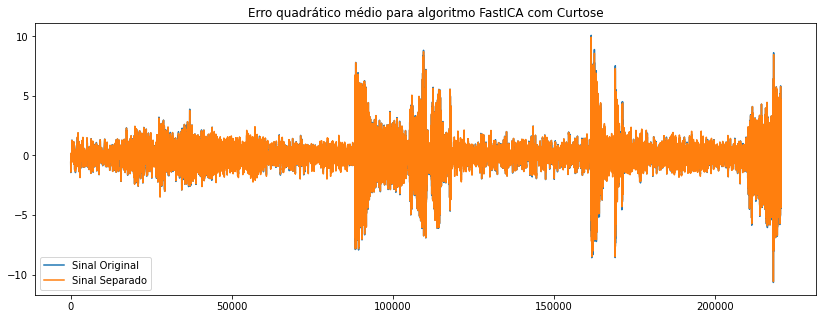

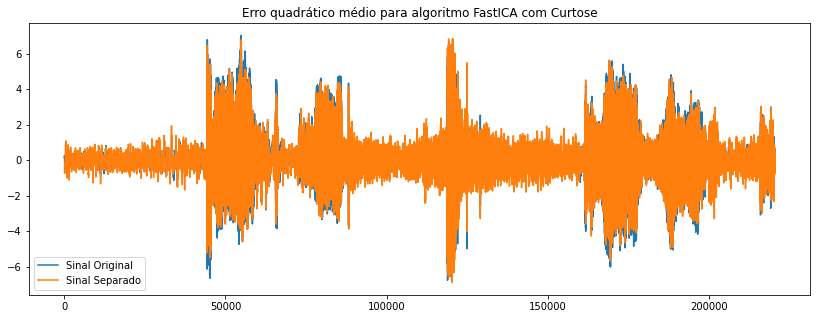

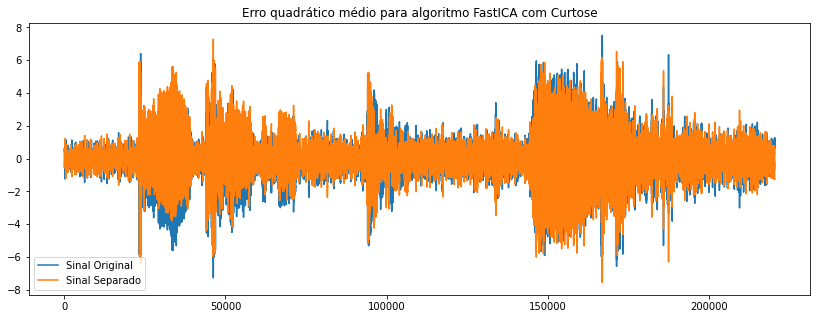

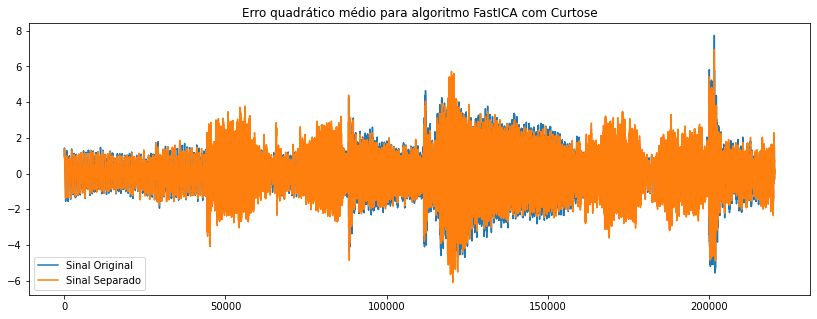

In [24]:
teste(S, X, curtose, w,A , white = True)

Nome do algoritmo: FastICA com Negentropia
O índice de Amari obtido para W é de 11.399167897115493
Correlação de Pearson vale 0.014847947799924856 entre a 1 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.526842870026224 entre a 1 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.6936157941845725 entre a 1 linha de S e a 3 linha de Y
Correlação de Pearson vale -0.49103284900946775 entre a 1 linha de S e a 4 linha de Y
Correlação de Pearson vale 0.028303516975013567 entre a 2 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.8281214039840635 entre a 2 linha de S e a 2 linha de Y
Correlação de Pearson vale -0.5492860500348976 entre a 2 linha de S e a 3 linha de Y
Correlação de Pearson vale 0.10816046610186096 entre a 2 linha de S e a 4 linha de Y
Correlação de Pearson vale -0.9990100337476935 entre a 3 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.03539712111940481 entre a 3 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.004621003543207757 entr

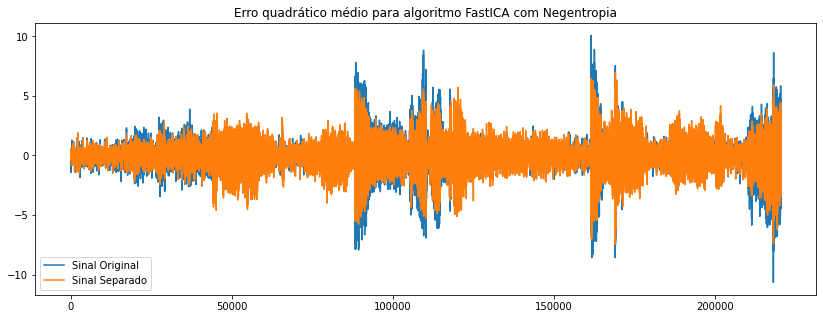

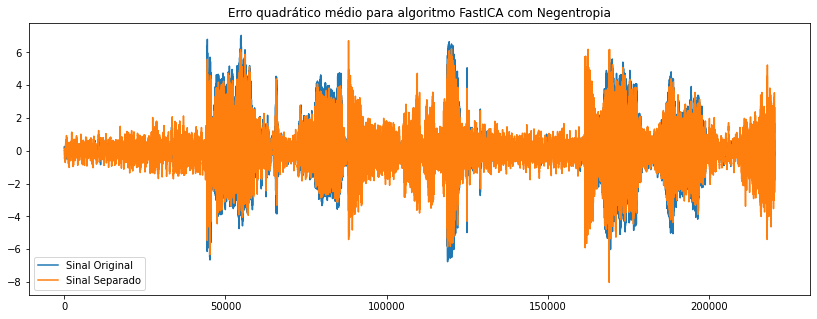

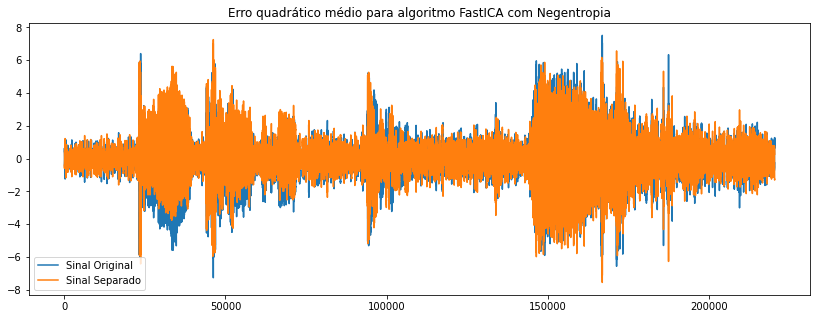

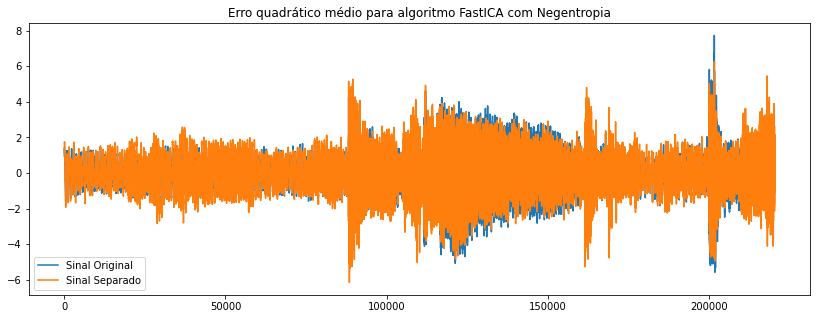

In [21]:
teste(S, X, negentropia, w, A, white = True)

Nome do algoritmo: Infomax
O índice de Amari obtido para W é de 10.957401682724672
Correlação de Pearson vale -0.13641499522422199 entre a 1 linha de S e a 1 linha de Y
Correlação de Pearson vale 0.12437718575589368 entre a 1 linha de S e a 2 linha de Y
Correlação de Pearson vale -0.011917045316325292 entre a 1 linha de S e a 3 linha de Y
Correlação de Pearson vale 0.15923694306922245 entre a 1 linha de S e a 4 linha de Y
Correlação de Pearson vale 0.2158347568603209 entre a 2 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.8364903288313162 entre a 2 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.3953919070749587 entre a 2 linha de S e a 3 linha de Y
Correlação de Pearson vale 0.680979867680299 entre a 2 linha de S e a 4 linha de Y
Correlação de Pearson vale -0.8712069334336167 entre a 3 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.5070092122181376 entre a 3 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.8830814368293476 entre a 3 linha de S e

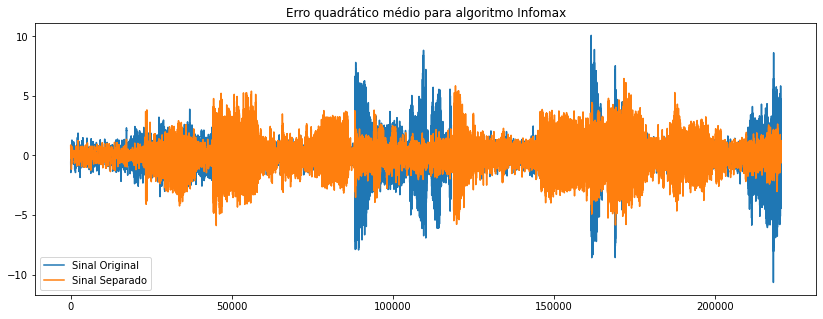

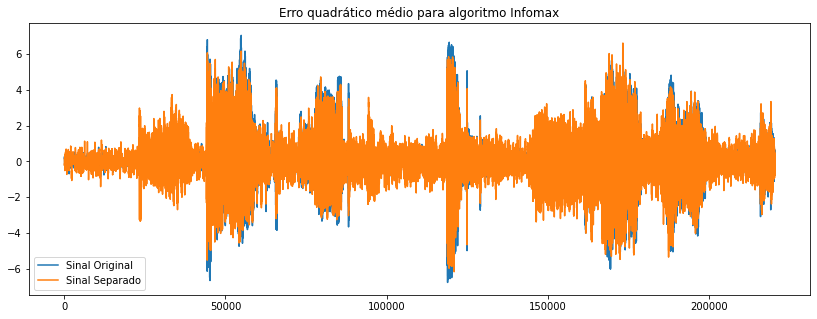

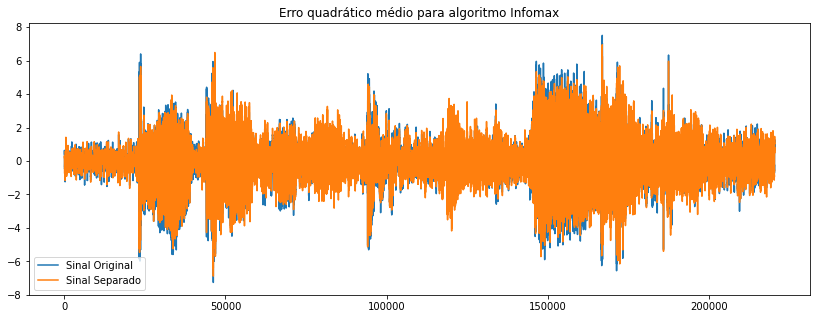

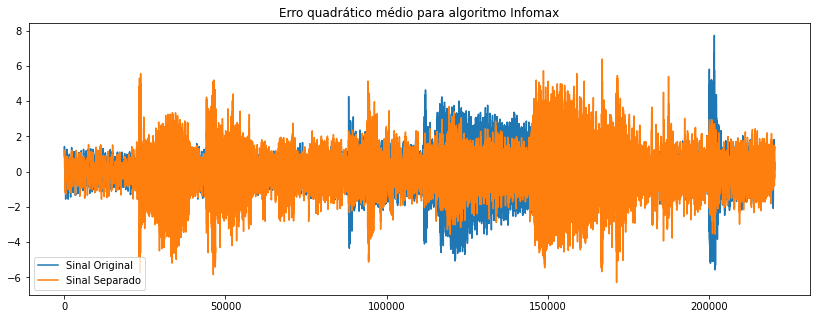

In [22]:
teste(S = S, X = X, algoritmo = infomax,w = winfomax, A = A, rate = 0.001, white=False)